In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

from surprise import Dataset
from surprise import Reader
from surprise import NMF

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Ponemos una semilla fija para que el experimento sea reusable
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

# 4. Calculo Factorización de Matrices

En este notebook entrenaremos la factorización de matrices aplicando el algoritmo **NMF**. Una vez entrenado, ya tendremos la matriz $P$ (relaciona usuario con las dimensiones) y la matriz $Q$ (relaciona películas con dimensiones). Al final, en la carpeta `data/matrices_data` tendremos la matriz $Q_u$ de cada usuario. Esto es la matriz $Q$ multiplicada por el vector en $P$ de cada usuario.

## 4.1. Preparar dataset

Separaremos los datos de los ratings en 2 grupos, entrenamiento (que tendrá el 90% de los datos) y evaluación (que tendrá el 10% de los datos).

In [2]:
def train_test_split(dataDF, training_percentage):
    '''
    Función que divide el dataset en un conjunto de entrenamiento y
    otro conjunto de evaluación.
    '''
    msk = np.random.rand(len(dataDF)) < float(training_percentage / 100)
    train = dataDF[msk]
    test = dataDF[~msk]
    
    return train, test    

In [3]:
# Cargamos todos los ratings del experimento
ratings_DF = pd.read_csv('data/experiment_data/ratings.csv')
ratings_DF.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,47,5.0,964983815
2,1,50,5.0,964982931
3,1,70,3.0,964982400
4,1,101,5.0,964980868


In [4]:
# Calculamos el porcentaje de la matriz completado

num_users = len(ratings_DF.groupby('userId').count().index)
num_items = len(ratings_DF.groupby('movieId').count().index)
total_ratings = len(ratings_DF)
total_values_to_predict = num_users * num_items

print(100*(total_ratings / total_values_to_predict), '% ratings conocidos del total de la matriz')

11.92192628910957 % ratings conocidos del total de la matriz


In [5]:
total_ratings

11477

In [6]:
# Preparamos el dataset de entrenamiento y evaluación
trainset, testset = train_test_split(ratings_DF, 90)

# Guardamos ambos dataframes en CSV
trainset.to_csv('data/experiment_data/trainset.csv', index=False)
testset.to_csv('data/experiment_data/testset.csv', index=False)

In [7]:
testset[testset['userId'] == 545]

,userId,movieId,rating,timestamp
9885,545,44,2.5,1240358381


## 4.2. Entrenamiento del algoritmo

Del nuevo dataset que hemos creado, calculamos las matrices P y Q usando el algoritmode NMF definido en la librería surprise.

In [8]:
# Cargamos los datasets
trainset_DF = pd.read_csv('data/experiment_data/trainset.csv', usecols=[0,1,2])
testset_DF = pd.read_csv('data/experiment_data/testset.csv', usecols=[0,1,2])

# Preparamos los datos de entrenamiento y evaluación

reader = Reader(rating_scale=(1,5))

train_data = Dataset.load_from_df(trainset_DF, reader).build_full_trainset()
test_data = Dataset.load_from_df(testset_DF, reader).build_full_trainset().build_testset()

# Seleccionamos el algoritmo
recommendation_algorithm = NMF()

# Entrenamos el algoritmo
recommendation_algorithm.fit(train_data)

# Obetenmos las predicciones
predictions = recommendation_algorithm.test(test_data)

# Mostramos las predicciones
predictions_df = pd.DataFrame(predictions, columns=['userId', 'movieId', 'realRating', 'estRating', 'details']).drop(columns='details')
predictions_df.head()

,userId,movieId,realRating,estRating
0,1,223,3.0,3.611623
1,1,349,4.0,4.004865
2,1,527,5.0,4.146800
3,3,527,0.5,3.610407
4,4,357,3.0,2.097807


In [9]:
predictions_df[predictions_df['userId'] == 545]

,userId,movieId,realRating,estRating
987,545,44,2.5,3.610407


In [10]:
predictions_df.to_csv('data/experiment_data/predicted_values.csv', index=False)

## 4.3. Calculamos las matrices $Q_u$

A continuación, calculamos las matrices $Q_u$ de cada usuario y lo guardamos en ficheros CSV.

In [11]:
# Obtenemos las matrices P y Q
p = pd.DataFrame(recommendation_algorithm.pu)
p['userId'] = sorted(list(set(trainset_DF['userId'])))
p.set_index('userId',inplace=True)
p.reset_index(inplace=True)

q = recommendation_algorithm.qi

In [12]:
# Por cada usuario calculamos su Qu y la gaurdamos en un CSV

for u in tqdm(range(len(p))):
    user_id = int(p.loc[u]['userId'])
    user_vector = p.loc[u][1:].values

    q_u = user_vector * q
    q_u_df = pd.DataFrame(q_u)
    q_u_df['movieId'] = sorted(list(set(trainset_DF['movieId'])))
    q_u_df.set_index('movieId', inplace=True)
    q_u_df.reset_index(inplace=True)
    
    path = 'data/matrices_data/q_user_' + str(user_id) + '.csv'
    q_u_df.to_csv(path, index=False)

100%|████████████████████████████████████████| 584/584 [00:04<00:00, 142.34it/s]


## 4.4. Calcular la predicción de ratings a partir de Qu

In [13]:
def get_predicted_rating(row):
    user = int(row['userId'])
    movie = int(row['movieId'])
    
    q_u = pd.read_csv('data/matrices_data/q_user_' + str(user) + '.csv')
    values = q_u[q_u['movieId'] == movie].values[0]
    return np.sum(values[1:])

In [14]:
testset_DF = testset_DF[testset_DF['userId'].isin(set(trainset_DF['userId']))]

In [15]:
testset_DF['predicted'] = testset_DF.apply(lambda row: get_predicted_rating(row), axis=1)
testset_DF.head()

,userId,movieId,rating,predicted
0,1,223,3.0,4.042081
1,1,349,4.0,2.726556
2,1,527,5.0,2.743715
4,4,357,3.0,2.737091
5,5,110,4.0,3.492654


In [16]:
testset_DF.to_csv('data/experiment_data/predicted_values.csv', index=False)

## 4.5. Visualizar matrices

En esta sección se pueden visualizar las matrices $Q_u$. Se muestra un mapa de calor de la matriz y un analisis estádistico de cada uno de los factores de la matriz $Q_u$. 

In [17]:
# Seleccionar el usuario que vamos a mostrar
user_id = 10
path = 'data/matrices_data/q_user_' + str(user_id) + '.csv'

In [18]:
q_u_DF = pd.read_csv(path)
q_u_DF.head()

,movieId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,0.015697,1.241905,0.184154,0.010867,0.008617,0.005733,0.057567,0.157174,0.101920,0.074246,0.036337,0.046276,0.770280,0.001008,0.626503
1,10,0.020905,1.012212,0.372804,0.084930,0.005563,0.001664,0.097089,0.113753,0.070802,0.020531,0.085962,0.040904,0.364721,0.001249,0.394769
2,11,0.016817,0.823237,0.079074,0.118290,0.001744,0.004018,0.092733,0.088147,0.004614,0.096103,0.079233,0.120291,0.826047,0.000846,0.680266
3,14,0.005627,0.280090,0.139792,0.029234,0.002614,0.002208,0.102459,0.055181,0.094801,0.100267,0.109218,0.030140,0.674024,0.002827,0.346577
4,15,0.013309,0.051371,0.076494,0.039331,0.012258,0.002591,0.043500,0.001520,0.064135,0.034993,0.058367,0.187575,0.792914,0.001261,0.737856


In [19]:
q_u_describe = q_u_DF.describe()
q_u_describe

,movieId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,164.000000,164.000000,164.000000,164.000000,164.000000,1.640000e+02,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,1.640000e+02,164.000000
mean,283.335366,0.010465,0.786730,0.269630,0.042265,5.369037e-03,0.004340,0.056949,0.087625,0.075990,0.073484,0.052708,0.052416,0.637993,9.702955e-04,0.360281
std,185.085398,0.007569,0.526437,0.173822,0.029604,3.423490e-03,0.002936,0.036109,0.056342,0.048200,0.045894,0.034773,0.037283,0.360679,6.274353e-04,0.254777
min,1.000000,0.000260,0.000232,0.001807,0.001479,1.266817e-08,0.000007,0.001087,0.000627,0.001141,0.000239,0.000028,0.000032,0.009358,4.070145e-07,0.001035
25%,111.750000,0.004542,0.409771,0.139270,0.016530,2.473798e-03,0.001812,0.026262,0.047016,0.037445,0.036362,0.026507,0.021717,0.365909,5.004141e-04,0.155757
50%,263.500000,0.008634,0.696948,0.262463,0.039173,5.276037e-03,0.004075,0.052295,0.080103,0.071759,0.071719,0.049120,0.043309,0.640794,8.735965e-04,0.328599
75%,444.250000,0.016306,1.120103,0.358995,0.057428,7.685304e-03,0.006196,0.087347,0.130821,0.106261,0.100956,0.074686,0.081908,0.860838,1.285330e-03,0.505593
max,610.000000,0.031372,2.421031,1.064599,0.149688,1.459991e-02,0.013211,0.154220,0.243378,0.214120,0.239373,0.150386,0.187575,1.784494,2.921267e-03,1.076413


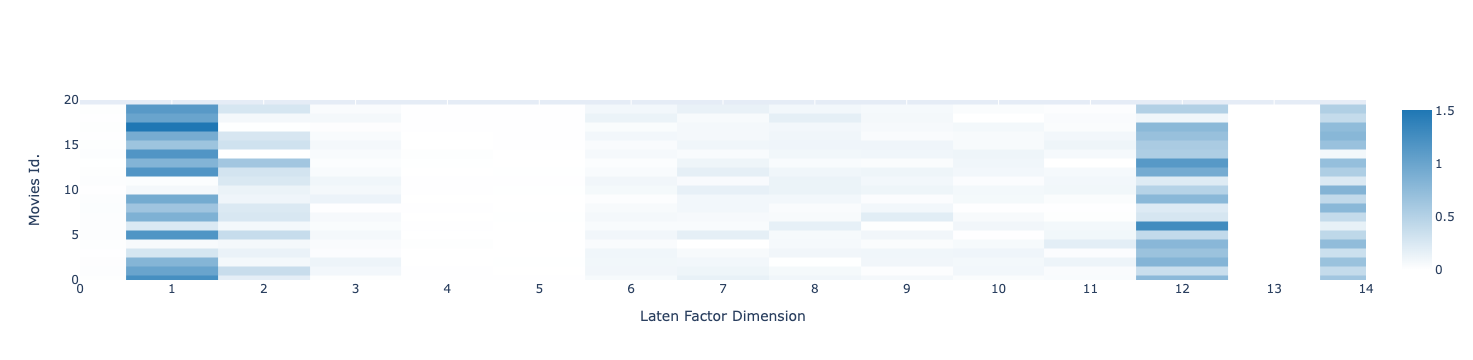

In [20]:
trace = go.Heatmap(z=q_u_DF.iloc[:,1:].values[:20],
                   x=q_u_DF.columns[1:].values,
                   y=q_u_DF.index.values[:20],
                   colorscale=[[0.0, 'rgb(255,255,255)'], [1.0, 'rgb(31, 119, 180)']])

layout = go.Layout(
    xaxis=dict(
        title='Laten Factor Dimension',
        range=[0, 14]
    ),
    yaxis=dict(
        title='Movies Id.',
        range=[0, 20]
    )
)


data=[trace]

fig = go.Figure(data=data, layout=layout)

#iplot(data, filename='labelled-heatmap')
iplot(fig, filename='axes-range-manual')

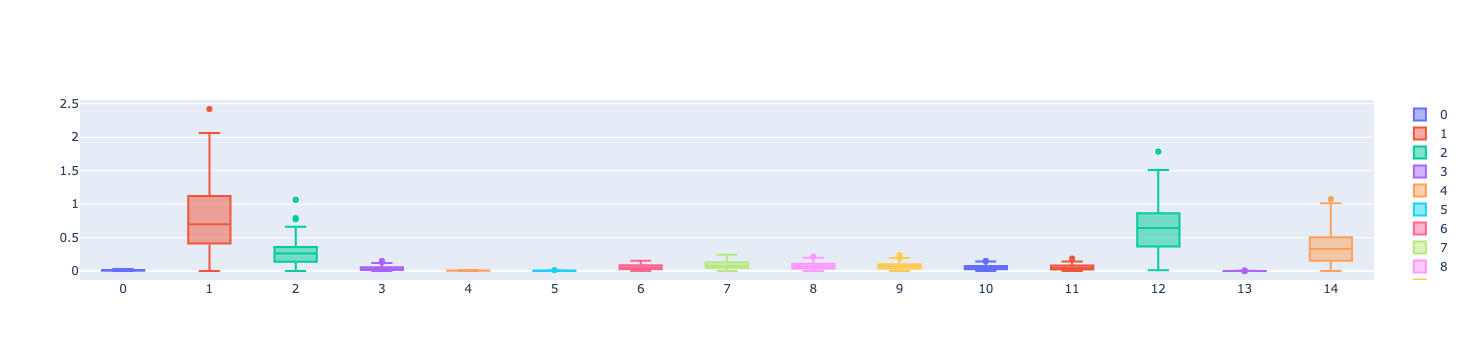

In [21]:
aux = q_u_DF.drop(columns=['movieId']).transpose()
data = []
for i in range(len(aux)):
    trace = go.Box(
        y = aux.iloc[i,:].values,
        name = str(i)
    )

    data.append(trace)

iplot(data)

### Siguiente Notebook

Una vez calculado las matrices $Q$ por cada usuario ya podemos obtener películas similares a partir de esa información y estudiar las características en común. Ejecute el notebook `recomendador_con_explicaciones.ipynb`.